<a href="https://colab.research.google.com/github/fid0did0/WebScraper/blob/main/ita_anleihen_web_scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update > /dev/null
!apt-get install -y chromium-chromedriver > /dev/null
!pip install selenium > /dev/null

In [2]:
import sys
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.relative_locator import locate_with
from selenium.common.exceptions import WebDriverException
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import numpy as np
import datetime
import re

options = Options()
#options.add_argument("--disable-dev-shm-usage")
options.add_argument("--no-sandbox")
options.add_argument('--headless')

# Launch Chrome browser
driver = webdriver.Chrome(options=options)

In [3]:
# I need to wait that new page is loaded.
# Only way is to see when first row change content
# as ex. when isin(/html/body/app-root/app-wrapper/div/div[2]/app-global-search-result-overview/div/div[2]/table/tbody/tr[1]/td[2]/a)
# change.
class PgChecker:
  def __init__(self):
    self.prev_isin = ''
  def prepare(self, driver):
    frst_isin_xpath="/html/body/app-root/app-wrapper/div/div[2]/app-global-search-result-overview/div/div[2]/table/tbody/tr[1]/td[2]/a"
    element_to_chck = driver.find_element(By.XPATH, frst_isin_xpath)
    self.prev_isin=element_to_chck.text
  def got_next_pg(self, driver):
    frst_isin_xpath="/html/body/app-root/app-wrapper/div/div[2]/app-global-search-result-overview/div/div[2]/table/tbody/tr[1]/td[2]/a"
    element_to_chck = driver.find_element(By.XPATH, frst_isin_xpath)
    if element_to_chck.text==self.prev_isin:
      return False
    else:
      return True

In [5]:
driver.get("https://www.boerse-frankfurt.de/suchergebnisse/italien")

anleihen_button_xpath="/html/body/app-root/app-wrapper/div/div[2]/app-global-search-result-overview/div/app-data-menue/div/div/div/drag-scroll/div/div/button[1]"
# in Frankreich was   /html/body/app-root/app-wrapper/div/div[2]/app-global-search-result-overview/div/app-page-bar[1]/div/div/button[6]
next_pg_button_xpath="/html/body/app-root/app-wrapper/div/div[2]/app-global-search-result-overview/div/app-page-bar[1]/div/div/button[8]"

WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.XPATH, anleihen_button_xpath)))

anleihen_button = driver.find_element(By.XPATH, anleihen_button_xpath)
stich_button = driver.find_element(By.XPATH, '/html/body/app-root/app-wrapper/div/div[2]/app-global-search-result-overview/div/app-data-menue/div/div/div/drag-scroll/div/div/button[2]')

anleihen_button.click()
WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.XPATH, next_pg_button_xpath)))

PgChecker_inst=PgChecker()
entry_link_list = []
scan_page=True
#for page_idx in range(5):
page_idx=0
while scan_page:
  page_idx=page_idx+1
  #print("start processing page %d" % page_idx)
  next_pg_button=driver.find_element(By.XPATH, next_pg_button_xpath)
  entry_na = False
  k=0
  while not entry_na:
    k=k+1
    entry_xpath='/html/body/app-root/app-wrapper/div/div[2]/app-global-search-result-overview/div/div[2]/table/tbody/tr[%d]/td[1]/a' % (k)
    try:
      entry = driver.find_element(By.XPATH, entry_xpath)
    except WebDriverException:
      entry_na = True

    if not entry_na:
      entry_link_list.append(entry.get_attribute("href"))

  if next_pg_button.get_attribute("disabled"):
    print("last page %d downloaded" % page_idx)
    scan_page=False
  else:
    print("page %d downloaded" % page_idx)
    PgChecker_inst.prepare(driver)
    next_pg_button.click()
    WebDriverWait(driver, 10).until(PgChecker_inst.got_next_pg)


page 1 downloaded
page 2 downloaded
page 3 downloaded
page 4 downloaded
last page 5 downloaded


In [14]:
ita_df = pd.DataFrame(columns=('title', 'expiry_year', 'price', 'rendite'))

frame_idx=0
for enty_link_iter in entry_link_list:
  #print(enty_link_iter)
  driver.get(enty_link_iter)
  anleihe_name_xpath = "/html/body/app-root/app-wrapper/div/div[2]/app-bond/div[1]/div/app-widget-datasheet-header/div/div/div/div/div[1]/div/h1"
  ablauf_date_xpath = "/html/body/app-root/app-wrapper/div/div[2]/app-bond/div[2]/div[5]/div[1]/app-widget-master-data-bond/div/div/table/tbody/tr[7]"
  price_xpath = "/html/body/app-root/app-wrapper/div/div[2]/app-bond/div[2]/div[2]/div[2]/div/div[1]/app-widget-price-box/div/div/table/tbody/tr[1]/td[2]"
  WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.XPATH, ablauf_date_xpath)))
  WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.XPATH, price_xpath)))

  anleihe_name = driver.find_element(By.XPATH, anleihe_name_xpath)
  frame_dic = {'title': anleihe_name.text}
  #print(anleihe_name.text)
  anleihe_name_tok_lst=re.search(r'Italien, Republik (.*)%.(\d+)/(\d+)', anleihe_name.text)
  #print(anleihe_name_tok_lst.groups())
  last_year=anleihe_name_tok_lst.groups()[2]
  #print(last_year)
  frame_dic['expiry_year'] = int(last_year)

  curs_tab = driver.find_element(By.TAG_NAME, "app-widget-price-box")
  last_price = curs_tab.find_element(By.XPATH, "div/div/table/tbody/tr[1]/td[2]")
  #print(last_price.text)
  if last_price.text=='-':
    last_price = float(100)
    last_price_na = True
    frame_dic['price'] = np.nan
  else:
    last_price_na = False
    last_price = float(last_price.text.replace(",","."))
    frame_dic['price'] = last_price

  interest_tab = driver.find_element(By.TAG_NAME, "app-widget-interest-rate")
  kupon = interest_tab.find_element(By.XPATH, "div/div/table/tbody/tr[1]/td[2]")
  #print(kupon.text)
  if kupon.text:
    interest_rate=float(kupon.text.replace("%", "").replace(",", "."))
  else:
    interest_rate=float(0)

  #print(interest_rate)

  master_data_tab = driver.find_element(By.TAG_NAME, "app-widget-master-data-bond")
  emission_date_str = master_data_tab.find_element(By.XPATH, "div/div/table/tbody/tr[7]/td[2]").text
  emission_date_lst = re.findall(r'\d+', emission_date_str)
  if emission_date_lst:
    emission_date_na = False
    emission_date = datetime.date(int(emission_date_lst[2]), int(emission_date_lst[1]), int(emission_date_lst[0]))
  else:
    emission_date_na = True
  #print(emission_date)
  current_date = datetime.date.today()
  expiry_date = emission_date.replace(year = 2000+int(last_year))
  duration=(expiry_date-current_date).days
  #print(expiry_date)
  #print(duration)

  #rendite_tab = driver.find_element(By.TAG_NAME, "app-widget-key-figures")
  #try:
  #  rendite = rendite_tab.find_element(By.XPATH, "div/div/table/tbody/tr[1]/td[2]")
  #  rendite_txt=rendite.text
  #except NoSuchElementException:
  #  rendite_txt="N/A"

  if last_price_na or emission_date_na:
    print("%-40sprice: ------\trendite:    N/A" % (anleihe_name.text))
    frame_dic['rendite'] = np.nan
  else:
    rendite_interest = interest_rate/(last_price/100)
    #print(rendite_interest)
    rendite_capital = (100-last_price)/(duration/365)/(last_price/100)
    #print(rendite_capital)
    rendite = rendite_interest + rendite_capital
    frame_dic['rendite'] = rendite
    print("%-40sprice: %6.2f\trendite: %5.2f%%" % (anleihe_name.text, last_price, rendite))

  ita_df.loc[frame_idx] = frame_dic
  frame_idx=frame_idx+1

Italien, Republik 4,45% 22/43           price:  95.83	rendite:  4.86%
Italien, Republik 3,5% 22/26            price:  99.81	rendite:  3.57%
Italien, Republik 1,7% 20/51            price:  55.81	rendite:  5.86%
Italien, Republik 9% 93/23              price: 100.60	rendite:  6.47%
Italien, Republik 3,85% 23/26           price: 100.68	rendite:  3.60%
Italien, Republik 5,125% 04/24          price: 102.24	rendite:  0.69%
Italien, Republik 4% 05/37              price:  95.66	rendite:  4.51%
Italien, Republik 3,6% 23/25            price:  99.94	rendite:  3.64%
Italien, Republik 1,75% 19/24           price:  98.25	rendite:  4.50%
Italien, Republik 4,4% 22/33            price: 102.22	rendite:  4.09%
Italien, Republik 5% 09/25              price: 100.99	rendite:  4.33%
Italien, Republik 0,000% 20/24          price:  98.28	rendite:  1.47%
Italien, Republik 3,75% 14/24           price:  99.48	rendite:  4.68%
Italien, Republik 4,75% 13/44           price: 102.25	rendite:  4.54%
Italien, Republik 0,

In [15]:
ita_df.sort_values(by='rendite', ascending=False).head(15)

,title,expiry_year,price,rendite
123,"Italien, Republik 0,65% 16/23",23,98.95,10.103649
87,"Italien, Republik 0,65% 16/23",23,98.95,10.103649
3,"Italien, Republik 9% 93/23",23,100.60,6.472528
44,"Italien, Republik 6% 98/28",28,100.00,6.000000
2,"Italien, Republik 1,7% 20/51",51,55.81,5.864507
111,"Italien, Republik 1,5% 20/45",45,59.60,5.563025
21,"Italien, Republik 2,15% 21/72",72,56.30,5.415765
19,"Italien, Republik 0,95% 21/37",37,65.87,5.294786
89,"Italien, Republik 1,8% 20/41",41,68.00,5.243261
30,"Italien, Republik 2,8% 16/67",67,67.50,5.239841


<Axes: xlabel='expiry_year', ylabel='rendite'>

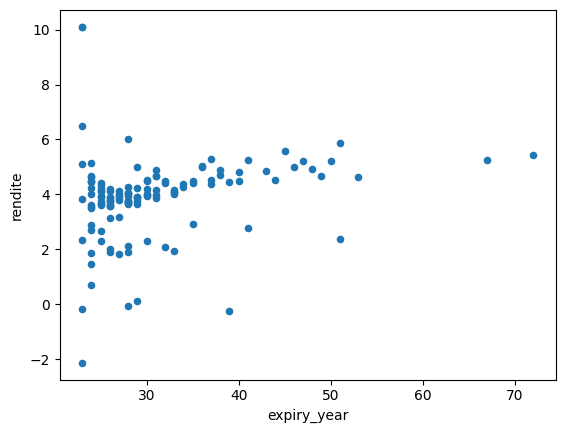

In [16]:
ita_df.plot(x='expiry_year', y='rendite', kind='scatter')

In [ ]:

driver.quit()
